## Data 255 - Lab2 Part 3

### Part 3 - PDF RAG LLM with Langchain

In [1]:
import os
import openai
from langchain.document_loaders import PyPDFLoader

from chromadb import Client
import re

**Importing API Key from environment file**

In [2]:
from dotenv import load_dotenv
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if openai_api_key is None:
    raise ValueError("API key is not set. Please set the OPENAI_API_KEY environment variable.")

In [3]:
pdf_directory = "./pdf/"

if not os.path.isdir(pdf_directory):
    raise ValueError(f"The directory {pdf_directory} does not exist!")

**Loading PDF files from the source directory**

In [4]:
pdf_files = [f for f in os.listdir(pdf_directory) if f.endswith('.pdf')]

In [5]:
from langchain.schema import Document
documents = []

for pdf_file in pdf_files:
    pdf_path = os.path.join(pdf_directory, pdf_file)
    loader = PyPDFLoader(pdf_path)
    
    loaded_documents = loader.load()
    
    for doc in loaded_documents:
        documents.append(Document(metadata=doc.metadata, page_content=doc.page_content))

In [6]:
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter
import os

In [7]:
openai.api_key = openai_api_key

**Fetch OPEN AI Embeddings**

In [8]:
from langchain_openai import OpenAIEmbeddings
embed_model = OpenAIEmbeddings()

**Convert Loaded Document into chunks using Semantic Chunker**

In [9]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings

semantic_chunker = SemanticChunker(embed_model, breakpoint_threshold_type="percentile")

In [10]:
semantic_chunks = semantic_chunker.create_documents([d.page_content for d in documents])

**Creating Vectorstore using ChromaDB**

In [11]:
persist_directory = "./chroma_db_2"

In [12]:
!rm -r ./chroma_db_2

In [13]:
if not os.path.exists(persist_directory):
    os.makedirs(persist_directory)

vectorstore = Chroma.from_documents(semantic_chunks, embed_model, persist_directory=persist_directory)

In [14]:
retriever = vectorstore.as_retriever()

**Validate the Retriever**

In [15]:
retriever.invoke("How did Meta’s workforce change by the end of 2023?")

[Document(metadata={}, page_content='NEWS RELEASE\nMeta Reports Fourth Quarter and Full Year 2023Results; Initiates Quarterly Dividend\nMENLO PARK, Calif., Feb. 1, 2024 /PRNewswire/ -- Meta Platforms, Inc. (Nasdaq: META) today reported \x00nancial\nresults for the quarter and full year ended December 31, 2023. "We had a good quarter as our community and business continue to grow," said Mark Zuckerberg, Meta founder\nand CEO. "We\'ve made a lot of progress on our vision for advancing AI and the metaverse."\xa0\n\xa0\nFourth Quarter and Full Year 2023 Financial Highlights\n Three Months Ended December 31, \n\xa0% Change\n Twelve Months Ended December 31, \n% ChangeIn millions, except percentages and per\xa0share amounts \xa0 \xa0\xa02023 2022  2023 2022  \nRevenue $ 40,111 $ 32,165 25\xa0% $ 134,902 $ 116,609 16\xa0%\nCosts and expenses 23,727  25,766 (8)\xa0%  88,151  87,665 1\xa0%\nIncome from operations$ 16,384 $ 6,399 156\xa0% $ 46,751 $ 28,944 62\xa0%\nOperating margin 41\xa0%  20\x

In [16]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from rouge_score import rouge_scorer
from torchmetrics.text.rouge import ROUGEScore
from pprint import pprint
from langchain.chains import RetrievalQA
from langchain.retrievers.multi_query import MultiQueryRetriever

**Setup LLM for RAG Chain**

In [17]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

In [18]:
retriever = vectorstore.as_retriever()

In [19]:
rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={
        "prompt": PromptTemplate(
            template="""
            You are a helpful assistant for answering complex questions.
            Please answer the following question based on Context provided. 
            Use three sentences maximum and keep it concise.  
            Do not give bullet points in answers, it should be a single paragraph.
            If you don't know the answer, just say that you don't know.
            
            Context: {context} \n

            Question: {question} \n

            Answer:
            """,
            input_variables=["context", "question"],
        )
    },
)

In [20]:
def get_response(question):
    response = rag_chain.invoke({"query": question})
    answer = response["result"]
    return answer

**Fetch answers for questions using RAG Chain**

In [21]:
questions = [
             "1. How did Meta’s workforce change by the end of 2023?",
             "2. What is the report quarter, and when did it end?",
             "3. What were the key financial highlights this quarter(revenue, gross margin, operating expenses, operating margin, net income, and EPS. )?",
             "4. How much did Meta spend on restructuring for the whole year and Q4?",
             "5. What happened with Meta’s ad impressions and average price per ad in Q4 and for the whole year?",
             "6. What’s the revenue outlook for Q1 2024?",
             "7. What were Meta’s total costs and expenses for Q4 and the full year 2023?",
             "8. How much cash and marketable securities did Meta have on hand as of December 31, 2023?",
             "9. What were the main areas Meta invested in during 2023?",
             "10.How did the Family of Apps and Reality Labs perform in Q4 2023?",
             "11.How much free cash flow did Meta generate in Q4 and the full year 2023?",
             "12.Did Meta make any changes to its stock repurchase program or dividends for 2024?",
             "13.What risks did Meta highlight for 2024?",
             "14.What drove Meta’s revenue growth in Q4 2023?",
             "15.How did Reality Labs perform throughout 2023, and what’s Meta’s plan for 2024?"
            ]
answers_list=[]
for question in questions:
    answer = get_response(question)
    answers_list.append(answer)
    print("Question:", question)
    print("Answer:", answer)
    print("-------------------------")

Question: 1. How did Meta’s workforce change by the end of 2023?
Answer: Meta's headcount was 67,317 as of December 31, 2023, showing a decrease of 22% year-over-year.
-------------------------
Question: 2. What is the report quarter, and when did it end?
Answer: The report is for the fourth quarter of 2023, which ended on December 31, 2023.
-------------------------
Question: 3. What were the key financial highlights this quarter(revenue, gross margin, operating expenses, operating margin, net income, and EPS. )?
Answer: The key financial highlights for this quarter include revenue of $40.11 billion, operating expenses of $23.73 billion, operating margin of 41%, net income of $14.02 billion, and diluted earnings per share of $5.33.
-------------------------
Question: 4. How much did Meta spend on restructuring for the whole year and Q4?
Answer: Meta spent $3.45 billion on restructuring for the full year 2023 and $1.15 billion in the fourth quarter of 2023.
-------------------------
Qu

In [22]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], use_stemmer=True)
rouge = ROUGEScore()
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/shitgupt/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Calculate ROGUE Score for original vs response answers**

In [23]:
original_answers = [
    "Meta's headcount was 67,317 as of December 31, 2023, showing a decrease of 22% year-over-year.",
    "The reported quarter is the fourth quarter of 2023. It ended on December 31, 2023.",
    "The key financial highlights this quarter were: Revenue of $40.11 billion, operating margin of 41%, net income of $14.02 billion, and diluted earnings per share of $5.33. Operating expenses totaled $23.73 billion, resulting in a 156% increase in income from operations.",
    "Meta spent a total of $3.45 billion on restructuring for the full year 2023 and $1.15 billion in the fourth quarter of 2023.",
    "In the fourth quarter of 2023, ad impressions increased by 21% year-over-year, and the average price per ad increased by 2% year-over-year. For the full year 2023, ad impressions increased by 28% year-over-year, and the average price per ad decreased by 9% year-over-year.",
    "The revenue outlook for Q1 2024 is expected to be in the range of $34.5-37 billion, according to the CFO's commentary. This guidance assumes foreign currency neutrality to year-over-year total revenue growth at current exchange rates.",
    "Meta's total costs and expenses were $23.73 billion for Q4 2023 and $88.15 billion for the full year 2023.",
    "As of December 31, 2023, Meta Platforms, Inc. had $65.40 billion in cash, cash equivalents, and marketable securities on hand. Meta has $41.86 billion in cash and cash equivalents and $23.51 billion of marketable securities.", 
    "Meta invested in advancing artificial intelligence (AI) and the metaverse, as mentioned by CEO Mark Zuckerberg. Additionally, Meta focused on immersive experiences like augmented and virtual reality to build the next evolution in social technology. Also, Meta made significant progress in developing technologies for community growth and engagement, along with enhancing user experience over short-term financial results.",
    "In Q4 2023, the Family of Apps reported income from operations of $21,030 million, showing a significant increase from the previous year. On the other hand, Reality Labs had an operating loss of $4,646 million in the same quarter, indicating a decrease as compared to loss of $4.279 million in previous year.",
    "Meta generated $11.50 billion in free cash flow for the fourth quarter of 2023 and $43.01 billion for the full year 2023.",
    "Yes, Meta made changes to its stock repurchase program by announcing a $50 billion increase in its share repurchase authorization. Additionally, Meta initiated a quarterly cash dividend of $0.50 per share of outstanding common stock, payable on March 26, 2024. These changes were announced for fourth quarter and full year 2023 as part of Meta's financial results.",
    "Meta highlighted risks for 2024 including macroeconomic conditions,  retention or increase of users and engagement levels, reliance on advertising revenue, privacy and security concerns, competition, government actions impacting access to products, and regulatory developments. They also mentioned risks associated with acquisitions, security breaches, and managing geographically-dispersed operations. Additionally, they noted potential risks related to changes in market conditions affecting dividend payments.",
    "Meta's revenue growth in Q4 2023 was primarily driven by a 24% increase in advertising revenue, reaching $38.7 billion. Additionally, the company reported growth in other revenue streams such as Reality Labs, which contributed to the overall revenue growth. The company's focus on expanding its user base and engagement levels also played a role in driving revenue growth in Q4 2023 to $40.11 billion which is a 25% change as compared to 2022.",
    "Reality Labs had a loss in income from operations of $16,120 million for the full year 2023. Meta plans to advance its efforts in AI and Reality Labs in 2024, aiming to build on the progress made in immersive experiences like augmented and virtual reality."
]

pprint(rouge(answers_list, original_answers))

{'rouge1_fmeasure': tensor(0.7885),
 'rouge1_precision': tensor(0.8255),
 'rouge1_recall': tensor(0.7687),
 'rouge2_fmeasure': tensor(0.6735),
 'rouge2_precision': tensor(0.7042),
 'rouge2_recall': tensor(0.6571),
 'rougeL_fmeasure': tensor(0.7360),
 'rougeL_precision': tensor(0.7694),
 'rougeL_recall': tensor(0.7180),
 'rougeLsum_fmeasure': tensor(0.7738),
 'rougeLsum_precision': tensor(0.8098),
 'rougeLsum_recall': tensor(0.7545)}


**Converting to Dataframe for easy display**

In [24]:
import pandas as pd
data = {
    "Question": questions,
    "Answer": answers_list,
    "Original Answer": original_answers
}

df = pd.DataFrame(data)

In [25]:
display(df)

,Question,Answer,Original Answer
0,1. How did Meta’s workforce change by the end ...,"Meta's headcount was 67,317 as of December 31,...","Meta's headcount was 67,317 as of December 31,..."
1,"2. What is the report quarter, and when did it...","The report is for the fourth quarter of 2023, ...",The reported quarter is the fourth quarter of ...
2,3. What were the key financial highlights this...,The key financial highlights for this quarter ...,The key financial highlights this quarter were...
3,4. How much did Meta spend on restructuring fo...,Meta spent $3.45 billion on restructuring for ...,Meta spent a total of $3.45 billion on restruc...
4,5. What happened with Meta’s ad impressions an...,"In the fourth quarter of 2023, ad impressions ...","In the fourth quarter of 2023, ad impressions ..."
5,6. What’s the revenue outlook for Q1 2024?,The revenue outlook for Q1 2024 is expected to...,The revenue outlook for Q1 2024 is expected to...
6,7. What were Meta’s total costs and expenses f...,Meta's total costs and expenses were $23.73 bi...,Meta's total costs and expenses were $23.73 bi...
7,8. How much cash and marketable securities did...,"As of December 31, 2023, Meta Platforms, Inc. ...","As of December 31, 2023, Meta Platforms, Inc. ..."
8,9. What were the main areas Meta invested in d...,Meta invested in advancing AI and the metavers...,Meta invested in advancing artificial intellig...
9,10.How did the Family of Apps and Reality Labs...,"In Q4 2023, the Family of Apps reported income...","In Q4 2023, the Family of Apps reported income..."


In [26]:
def calculate_rouge_scores(answer, original_answer):
    scores = scorer.score(original_answer, answer)
    return scores['rouge1'].fmeasure, scores['rouge2'].fmeasure, scores['rougeL'].fmeasure, scores['rougeLsum'].fmeasure

In [27]:
df[['ROUGE-1', 'ROUGE-2', 'ROUGE-L','ROGUE-LSUM']] = df.apply(
    lambda row: pd.Series(calculate_rouge_scores(row['Answer'], row['Original Answer'])),
    axis=1
)

**Final DF with ROGUE scores for each question**

In [28]:
display(df)

,Question,Answer,Original Answer,ROUGE-1,ROUGE-2,ROUGE-L,ROGUE-LSUM
0,1. How did Meta’s workforce change by the end ...,"Meta's headcount was 67,317 as of December 31,...","Meta's headcount was 67,317 as of December 31,...",1.000000,1.000000,1.000000,1.000000
1,"2. What is the report quarter, and when did it...","The report is for the fourth quarter of 2023, ...",The reported quarter is the fourth quarter of ...,0.866667,0.642857,0.866667,0.866667
2,3. What were the key financial highlights this...,The key financial highlights for this quarter ...,The key financial highlights this quarter were...,0.829268,0.725000,0.707317,0.707317
3,4. How much did Meta spend on restructuring fo...,Meta spent $3.45 billion on restructuring for ...,Meta spent a total of $3.45 billion on restruc...,0.936170,0.888889,0.936170,0.936170
4,5. What happened with Meta’s ad impressions an...,"In the fourth quarter of 2023, ad impressions ...","In the fourth quarter of 2023, ad impressions ...",0.980392,0.960000,0.980392,0.980392
5,6. What’s the revenue outlook for Q1 2024?,The revenue outlook for Q1 2024 is expected to...,The revenue outlook for Q1 2024 is expected to...,0.808989,0.666667,0.719101,0.719101
6,7. What were Meta’s total costs and expenses f...,Meta's total costs and expenses were $23.73 bi...,Meta's total costs and expenses were $23.73 bi...,0.888889,0.837209,0.888889,0.888889
7,8. How much cash and marketable securities did...,"As of December 31, 2023, Meta Platforms, Inc. ...","As of December 31, 2023, Meta Platforms, Inc. ...",0.831169,0.666667,0.701299,0.701299
8,9. What were the main areas Meta invested in d...,Meta invested in advancing AI and the metavers...,Meta invested in advancing artificial intellig...,0.596774,0.459016,0.516129,0.516129
9,10.How did the Family of Apps and Reality Labs...,"In Q4 2023, the Family of Apps reported income...","In Q4 2023, the Family of Apps reported income...",0.666667,0.513761,0.630631,0.630631


In [29]:
df.to_csv('answers.csv')

**Perform Fine Tuning using JSONL File for OpenAI**

In [30]:
from openai import OpenAI

client = OpenAI(api_key=openai_api_key)

with open("finetune.jsonl", "rb") as file:
    response = client.files.create(
        file=file, 
        purpose="fine-tune"
    )

file_id = response.id

fine_tuning_job = client.fine_tuning.jobs.create(
    training_file=file_id, 
    model="gpt-3.5-turbo"
)

job = client.fine_tuning.jobs.retrieve(fine_tuning_job.id)

jobs = client.fine_tuning.jobs.list(limit=10)

In [31]:
print(job)

FineTuningJob(id='ftjob-ycMiaQcOQ1nErPnmy6QcPlKG', created_at=1733365730, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-J3RIeFeEZeBQp4CQG4Dk2xow', result_files=[], seed=808157084, status='validating_files', trained_tokens=None, training_file='file-JVLC6cKFrosEcNNT2rpB5Z', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)


In [32]:
job = client.fine_tuning.jobs.retrieve(fine_tuning_job.id)

In [33]:
print(job)

FineTuningJob(id='ftjob-ycMiaQcOQ1nErPnmy6QcPlKG', created_at=1733365730, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-J3RIeFeEZeBQp4CQG4Dk2xow', result_files=[], seed=808157084, status='validating_files', trained_tokens=None, training_file='file-JVLC6cKFrosEcNNT2rpB5Z', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)


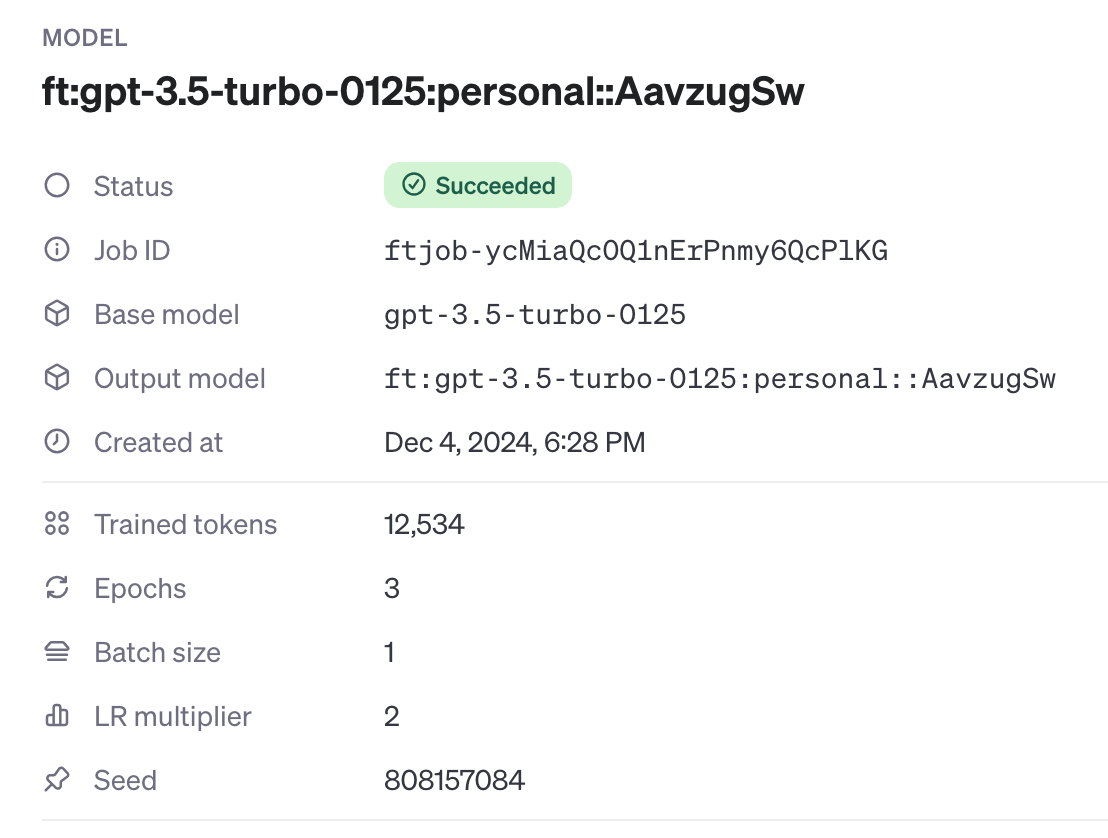

**Create new RAG Chain with Tuned Model**

In [34]:
llm_tuned = ChatOpenAI(model_name="ft:gpt-3.5-turbo-0125:personal::AavzugSw", temperature=0)

In [35]:
rag_chain = RetrievalQA.from_chain_type(
    llm=llm_tuned,
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={
        "prompt": PromptTemplate(
            template="""
            You are a helpful assistant for answering complex questions.
            Please answer the following question based on Context provided. 
            Use three sentences maximum and keep it concise.  
            Do not give bullet points in answers, it should be a single paragraph.
            If you don't know the answer, just say that you don't know.
            
            Context: {context} \n

            Question: {question} \n

            Answer:
            """,
            input_variables=["context", "question"],
        )
    },
)

In [36]:
def get_response(question):
    response = rag_chain.invoke({"query": question})
    answer = response["result"]
    return answer

In [37]:
questions = [
             "1. How did Meta’s workforce change by the end of 2023?",
             "2. What is the report quarter, and when did it end?",
             "3. What were the key financial highlights this quarter(revenue, gross margin, operating expenses, operating margin, net income, and EPS. )?",
             "4. How much did Meta spend on restructuring for the whole year and Q4?",
             "5. What happened with Meta’s ad impressions and average price per ad in Q4 and for the whole year?",
             "6. What’s the revenue outlook for Q1 2024?",
             "7. What were Meta’s total costs and expenses for Q4 and the full year 2023?",
             "8. How much cash and marketable securities did Meta have on hand as of December 31, 2023?",
             "9. What were the main areas Meta invested in during 2023?",
             "10.How did the Family of Apps and Reality Labs perform in Q4 2023?",
             "11.How much free cash flow did Meta generate in Q4 and the full year 2023?",
             "12.Did Meta make any changes to its stock repurchase program or dividends for 2024?",
             "13.What risks did Meta highlight for 2024?",
             "14.What drove Meta’s revenue growth in Q4 2023?",
             "15.How did Reality Labs perform throughout 2023, and what’s Meta’s plan for 2024?"
            ]
answers_list=[]
for question in questions:
    answer = get_response(question)
    answers_list.append(answer)
    print("Question:", question)
    print("Answer:", answer)
    print("-------------------------")

Question: 1. How did Meta’s workforce change by the end of 2023?
Answer: Meta's headcount was 67,317 as of December 31, 2023, which was a decrease of 22% year-over-year.
-------------------------
Question: 2. What is the report quarter, and when did it end?
Answer: The reported quarter is the fourth quarter of 2023, and it ended on December 31, 2023.
-------------------------
Question: 3. What were the key financial highlights this quarter(revenue, gross margin, operating expenses, operating margin, net income, and EPS. )?
Answer: Meta reported revenue of $40.11 billion, a 25% increase year-over-year, with net income of $14.02 billion, a 201% increase year-over-year. Operating expenses were $23.73 billion, an 8% decrease year-over-year, resulting in an operating margin of 41%. Diluted EPS was $5.33, a 203% increase year-over-year.
-------------------------
Question: 4. How much did Meta spend on restructuring for the whole year and Q4?
Answer: Meta spent $3.45 billion on restructuring 

In [38]:
data = {
    "Question": questions,
    "Answer": answers_list,
    "Original Answer": original_answers
}

# Convert the dictionary to a DataFrame
df_tuned = pd.DataFrame(data)

In [39]:
df_tuned[['ROUGE-1', 'ROUGE-2', 'ROUGE-L','ROGUE-LSUM']] = df.apply(
    lambda row: pd.Series(calculate_rouge_scores(row['Answer'], row['Original Answer'])),
    axis=1
)

**Calculate ROGUE Scores**

In [41]:
pprint(rouge(answers_list, original_answers))

{'rouge1_fmeasure': tensor(0.7231),
 'rouge1_precision': tensor(0.8482),
 'rouge1_recall': tensor(0.6623),
 'rouge2_fmeasure': tensor(0.5953),
 'rouge2_precision': tensor(0.6969),
 'rouge2_recall': tensor(0.5470),
 'rougeL_fmeasure': tensor(0.6682),
 'rougeL_precision': tensor(0.7798),
 'rougeL_recall': tensor(0.6136),
 'rougeLsum_fmeasure': tensor(0.6874),
 'rougeLsum_precision': tensor(0.8004),
 'rougeLsum_recall': tensor(0.6327)}


In [40]:
display(df_tuned)

,Question,Answer,Original Answer,ROUGE-1,ROUGE-2,ROUGE-L,ROGUE-LSUM
0,1. How did Meta’s workforce change by the end ...,"Meta's headcount was 67,317 as of December 31,...","Meta's headcount was 67,317 as of December 31,...",1.000000,1.000000,1.000000,1.000000
1,"2. What is the report quarter, and when did it...",The reported quarter is the fourth quarter of ...,The reported quarter is the fourth quarter of ...,0.866667,0.642857,0.866667,0.866667
2,3. What were the key financial highlights this...,"Meta reported revenue of $40.11 billion, a 25%...",The key financial highlights this quarter were...,0.829268,0.725000,0.707317,0.707317
3,4. How much did Meta spend on restructuring fo...,Meta spent $3.45 billion on restructuring for ...,Meta spent a total of $3.45 billion on restruc...,0.936170,0.888889,0.936170,0.936170
4,5. What happened with Meta’s ad impressions an...,"In the fourth quarter of 2023, ad impressions ...","In the fourth quarter of 2023, ad impressions ...",0.980392,0.960000,0.980392,0.980392
5,6. What’s the revenue outlook for Q1 2024?,Facebook expects first-quarter 2024 total reve...,The revenue outlook for Q1 2024 is expected to...,0.808989,0.666667,0.719101,0.719101
6,7. What were Meta’s total costs and expenses f...,Total costs and expenses were $23.73 billion f...,Meta's total costs and expenses were $23.73 bi...,0.888889,0.837209,0.888889,0.888889
7,8. How much cash and marketable securities did...,"Meta had $65.40 billion in cash, cash equivale...","As of December 31, 2023, Meta Platforms, Inc. ...",0.831169,0.666667,0.701299,0.701299
8,9. What were the main areas Meta invested in d...,Meta invested in advancing AI and the metavers...,Meta invested in advancing artificial intellig...,0.596774,0.459016,0.516129,0.516129
9,10.How did the Family of Apps and Reality Labs...,The Family of Apps reported $21.03 billion in ...,"In Q4 2023, the Family of Apps reported income...",0.666667,0.513761,0.630631,0.630631


In [42]:
df_tuned.to_csv("answers_tuned.csv")

**Based on the results from the fine-tuned model we can conclude that extensive data is needed to tune the exiting LLM. Creating data manually using the currently available knowledge base is very cumbersome process. As is visible from the results above, ROGUE scores were at par or showed a minor improvement for some questions. However, for others the performance was not as expected and it was better with the baseline gpt-turbo-3.5 model.**

**We were able to achieve a total rougeLsum_precision of 80% with our baseline model and prompts, however, to tune this further a large corpus of data might be needed. The difference observed in the original vs result answers is primarily due to the formation of the sentences. The numerical metrics are matching across the board.**

## Thank You